In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from os.path import dirname, join
import networkx as nx

from graspy.plot import heatmap
from graspy.utils import get_multigraph_intersect_lcc, is_symmetric, symmetrize

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc.mgc import MGC

from utils import estimate_block_assignment, to_distance_mtx, identity, sort_graph, binarize, pvalue, block_permute, _sort_inds

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Weighted, graph match

In [23]:
with open('../data/drosophila/seeds_weighted_P.pkl', 'rb') as f:
    w_graph_match = pickle.load(f)
w_graph_match = np.reshape(w_graph_match, (213, 213))

with open('../data/drosophila/weighted_left_permuted.pkl', 'rb') as f:
    left = pickle.load(f)
with open('../data/drosophila/weighted_right_permuted.pkl', 'rb') as f:
    right = pickle.load(f)

In [24]:
right_sorted = sort_graph(right, np.where(w_graph_match==1)[1])
right_nx = nx.from_numpy_matrix(right_sorted)
# remove the extra nodes in the right graphs, which match the nuisance nodes in left
right_nx.remove_nodes_from(np.arange(left.shape[0], right.shape[0]))
# right (removed nodes, not sorted)
right_rm = nx.to_numpy_array(right_nx)

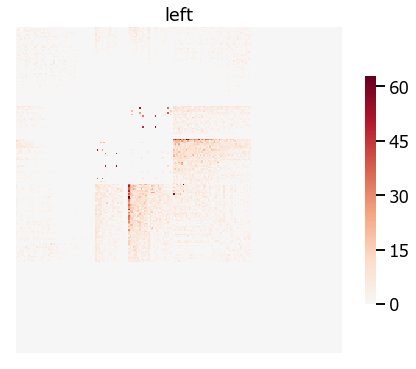

In [25]:
heatmap(left, title='left', figsize=(8, 6))

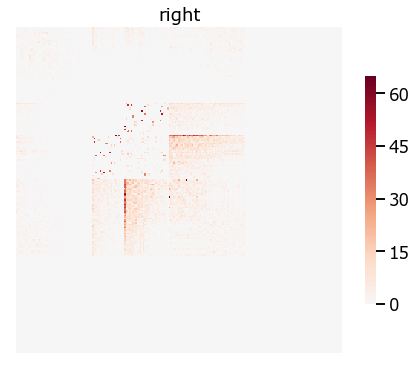

In [26]:
heatmap(right, title='right', figsize=(8, 6))

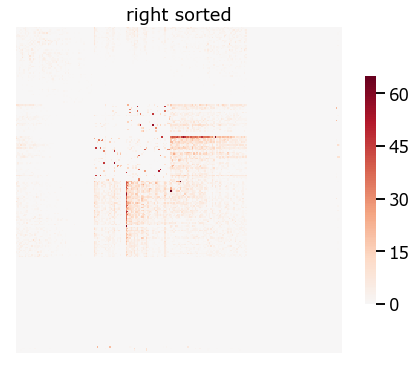

In [27]:
heatmap(right_sorted, title='right sorted', figsize=(8, 6))

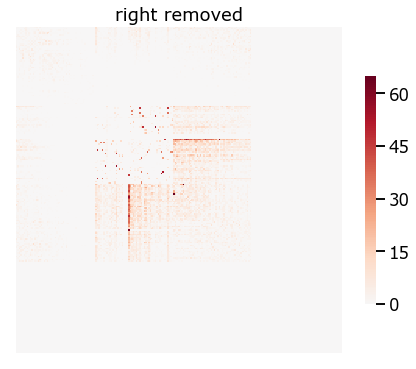

In [28]:
heatmap(right_rm, title='right removed', figsize=(8, 6))

In [29]:
block_assignment = estimate_block_assignment(left, right_rm, k=100, set_k=False, num_repeats=10)

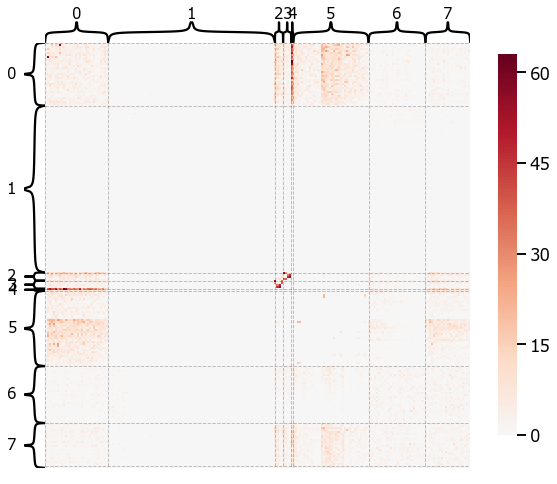

In [30]:
heatmap(left, inner_hier_labels=block_assignment, title='left')

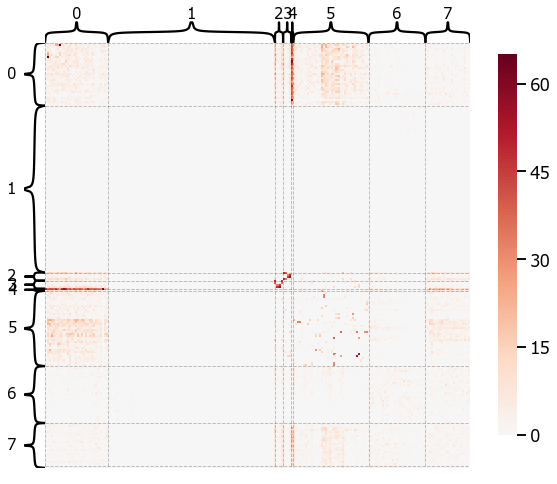

In [31]:
heatmap(right_rm, inner_hier_labels=block_assignment, title='right')

In [19]:
mgc = MGC(compute_distance_matrix=identity)

In [20]:
mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right_rm))

(0.739048660539342,
 {'local_correlation_matrix': array([[-4.58074855e-05,  1.98756067e-01,  2.72451649e-01, ...,
           1.47239067e-01,  1.47237612e-01,  1.47046337e-01],
         [ 4.16275950e-01,  7.46653985e-01,  7.06780401e-01, ...,
           6.82852922e-01,  6.82853227e-01,  6.82357383e-01],
         [ 3.10668150e-01,  7.47327477e-01,  7.47481350e-01, ...,
           7.04465240e-01,  7.04469086e-01,  7.04163781e-01],
         ...,
         [ 1.63360690e-01,  6.88799589e-01,  6.63986263e-01, ...,
           7.29261966e-01,  7.29304828e-01,  7.29861111e-01],
         [ 1.63362242e-01,  6.88150801e-01,  6.63537817e-01, ...,
           7.29011755e-01,  7.29054606e-01,  7.29610457e-01],
         [ 1.63128978e-01,  6.84774913e-01,  6.61174880e-01, ...,
           7.27934126e-01,  7.27975433e-01,  7.28448708e-01]]),
  'optimal_scale': [30, 14]})

In [11]:
k_arr = np.logspace(start=1, stop=7, num=7, base=2, dtype=int)
reps = 100
test_stats_null_arr = np.zeros((k_arr.size, reps))
for i, k in enumerate(k_arr):
    for r in tqdm(range(reps)):
        block_assignment = estimate_block_assignment(left, right_rm, k=k, set_k=True, num_repeats=50)
        test_stats_null, _ = mgc.test_statistic(to_distance_mtx(block_permute(left, block_assignment)), 
                   to_distance_mtx(sort_graph(right_rm, block_assignment)))
        test_stats_null_arr[i, r] = test_stats_null

100%|██████████| 100/100 [14:39<00:00,  8.58s/it]


In [12]:
np.save('../results/drosophila_weighted_teststats_null.npy', test_stats_null_arr)

In [3]:
def pval_from_null_dist(k):
    i = np.where(k_arr == k)[0][0]
    pval = np.where(test_stats_null_arr[i, :] >= test_stats_alt)[0].size / test_stats_null_arr.shape[1]
    return pval

In [16]:
for k in k_arr:
    print('k: {}, p-value: {}'.format(k, pval_from_null_dist(k)))

k: 2, p-value: 0.0
k: 4, p-value: 0.0
k: 8, p-value: 0.0
k: 16, p-value: 0.0
k: 32, p-value: 0.0
k: 64, p-value: 0.0
k: 128, p-value: 0.93


[]

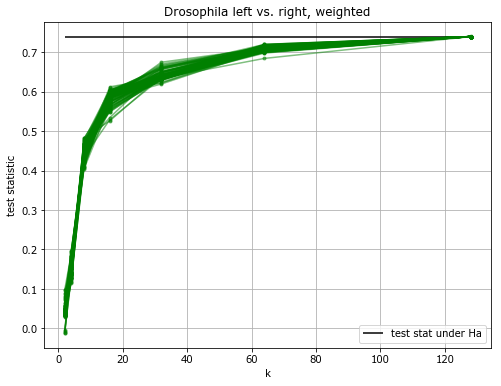

In [22]:
k_arr = np.logspace(start=1, stop=7, num=7, base=2, dtype=int)
test_stats_null_arr = np.load('../results/drosophila_weighted_teststats_null.npy')
test_stats_alt = mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right_rm))[0]
plt.figure(figsize=(8, 6))
for i in range(test_stats_null_arr.shape[1]):
    plt.plot(k_arr, test_stats_null_arr[:, i], color='g', marker='.', alpha=0.5)
plt.hlines(y=test_stats_alt, xmin=min(k_arr), xmax=max(k_arr), label='test stat under Ha')
plt.xlabel('k')
plt.ylabel('test statistic')
plt.title('Drosophila left vs. right, weighted')
plt.legend(loc=4)
plt.grid()
plt.plot()

In [44]:
with open('../results/drosophila_weighted_teststats_null.pkl', 'rb') as f:
    null = pickle.load(f)
null = dict(null)

test_stats_null_arr = np.zeros((k_arr.size, 500))
for i, k in enumerate(k_arr):
    test_stats_null_arr[i, :] = null[k]

test_stats_alt, _ = mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right[:left.shape[0], :left.shape[0]]))
plt.figure(figsize=(8, 6))
for i in range(test_stats_null_arr.shape[1]):
    plt.plot(k_arr, test_stats_null_arr[:, i], color='g', marker='.', alpha=0.5)
plt.hlines(y=test_stats_alt, xmin=min(k_arr), xmax=max(k_arr), label='test stat under Ha')
plt.xlabel('k')
plt.ylabel('test statistic')
plt.legend(loc=4)
plt.grid()
plt.plot()

### Unweighted, graph match

In [5]:
with open('../data/drosophila/seeds_unweighted_P.pkl', 'rb') as f:
    graph_match = pickle.load(f)
graph_match = np.reshape(graph_match, (213, 213))

with open('../data/drosophila/unweighted_left_permuted.pkl', 'rb') as f:
    left = pickle.load(f)
with open('../data/drosophila/unweighted_right_permuted.pkl', 'rb') as f:
    right = pickle.load(f)

In [6]:
left = np.where(left, 1, 0)
right = np.where(right, 1, 0)

In [7]:
right_sorted = sort_graph(right, np.where(graph_match==1)[1])
right_nx = nx.from_numpy_matrix(right_sorted)
right_nx.remove_nodes_from(np.arange(left.shape[0], right.shape[0]))
# right (removed nodes, not sorted)
right_rm = nx.to_numpy_array(right_nx)

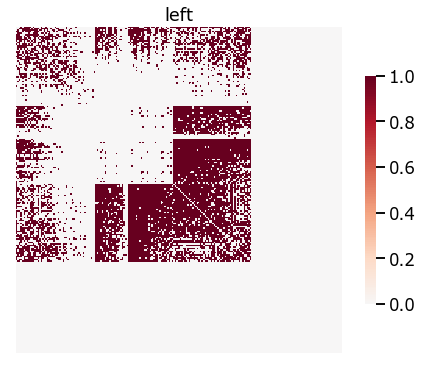

In [8]:
heatmap(left, figsize=(8, 6), title='left')

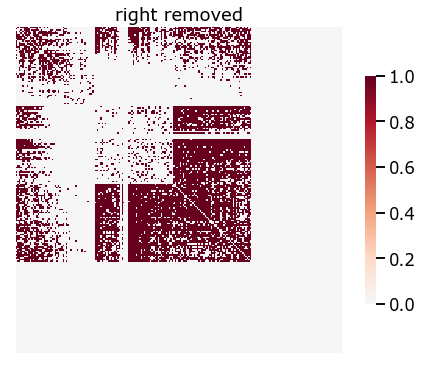

In [9]:
heatmap(right_rm, figsize=(8, 6), title='right removed')

In [9]:
block_assignment = estimate_block_assignment(left, right_rm, k=100, set_k=False, num_repeats=10)

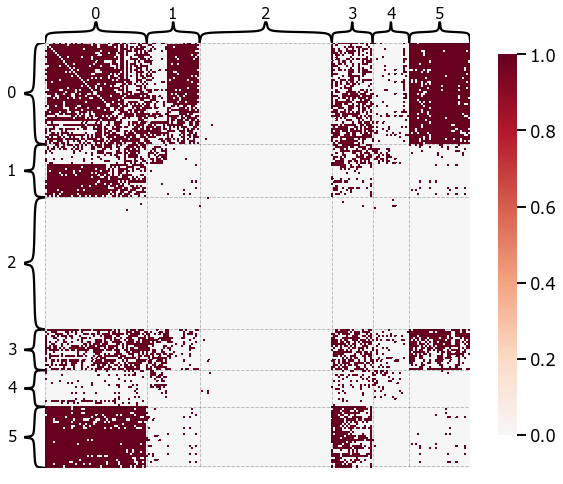

In [10]:
heatmap(left, inner_hier_labels=block_assignment, title='left')

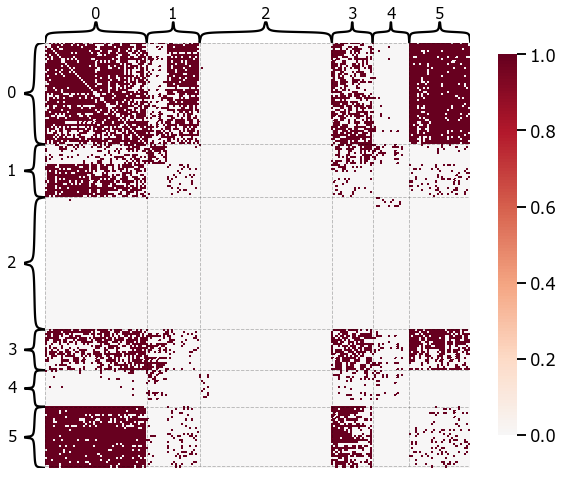

In [11]:
heatmap(right_rm, inner_hier_labels=block_assignment)

In [10]:
mgc = MGC(compute_distance_matrix=identity)

In [11]:
mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right_rm))

(0.6695986873583826,
 {'local_correlation_matrix': array([[0.66959869, 0.6354944 ],
         [0.63468054, 0.53171925]]), 'optimal_scale': [1, 1]})

In [10]:
k_arr = np.linspace(1, 15, 15, dtype=int)
reps = 100
test_stats_null_arr = np.zeros((k_arr.size, reps))
for i, k in enumerate(k_arr):
    for r in tqdm(range(reps)):
        block_assignment = estimate_block_assignment(left, right_rm, k=k, set_k=True, num_repeats=50)
        test_stats_null, _ = mgc.test_statistic(to_distance_mtx(block_permute(left, block_assignment)), 
                   to_distance_mtx(sort_graph(right_rm, block_assignment)))
        test_stats_null_arr[i, r] = test_stats_null

100%|██████████| 100/100 [02:13<00:00,  1.27s/it]


In [11]:
np.save('../results/drosophila_unweighted_teststats_null_k_15.npy', test_stats_null_arr)

In [12]:
for k in k_arr:
    print('k: {}, p-value: {}'.format(k, pval_from_null_dist(k)))

NameError: name 'pval_from_null_dist' is not defined

[]

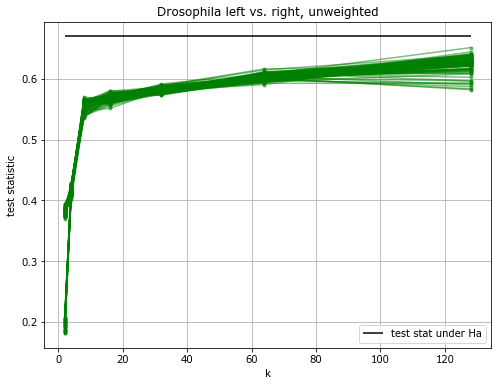

In [14]:
k_arr = np.logspace(start=1, stop=7, num=7, base=2, dtype=int)
test_stats_null_arr = np.load('../results/drosophila_unweighted_teststats_null.npy')
test_stats_alt = mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right_rm))[0]
plt.figure(figsize=(8, 6))
for i in range(test_stats_null_arr.shape[1]):
    plt.plot(k_arr, test_stats_null_arr[:, i], color='g', marker='.', alpha=0.5)
plt.hlines(y=test_stats_alt, xmin=min(k_arr), xmax=max(k_arr), label='test stat under Ha')
plt.xlabel('k')
plt.ylabel('test statistic')
plt.title('Drosophila left vs. right, unweighted')
plt.legend(loc=4)
plt.grid()
plt.plot()

### Remove additional nodes in each labels

In [5]:
left_labels = np.loadtxt('../data/drosophila/left_cell_labels.csv', dtype=str)
right_labels = np.loadtxt('../data/drosophila/right_cell_labels.csv', dtype=str)

In [6]:
np.unique(left_labels, return_counts=True)

(array(['I', 'K', 'O', 'P'], dtype='<U1'), array([ 21, 101,  29,  58]))

In [7]:
np.unique(right_labels, return_counts=True)

(array(['I', 'K', 'O', 'P'], dtype='<U1'), array([ 21, 100,  29,  63]))

In [8]:
P = np.zeros((213, 213))
for label in ['I', 'O']:
    left_idx = np.where(left_labels==label)[0]
    right_idx = np.where(right_labels==label)[0]
    P[left_idx, right_idx] = 1

In [9]:
left = np.loadtxt('../data/drosophila/left_adjacency.csv', dtype=int)
right = np.loadtxt('../data/drosophila/right_adjacency.csv', dtype=int)

# left and right, symmetrized
left = symmetrize(left)
right = symmetrize(right)

In [10]:
right_nx = nx.from_numpy_matrix(right)
#right_nx.remove_nodes_from(np.where(w_graph_match==1)[1][left.shape[0]:])
right_nx.remove_nodes_from(np.random.choice(np.where(right_labels=='P')[0], 5))
# right (removed nodes, not sorted)
right_rm = nx.to_numpy_array(right_nx)

left_nx = nx.from_numpy_matrix(left)
#right_nx.remove_nodes_from(np.where(w_graph_match==1)[1][left.shape[0]:])
left_nx.remove_nodes_from(np.random.choice(np.where(left_labels=='K')[0], 1))
# right (removed nodes, not sorted)
left_rm = nx.to_numpy_array(left_nx)

# right (removed nodes and sorted)
#right_sorted = sort_graph(right_rm, np.where(w_graph_match==1)[1][:left.shape[0]])

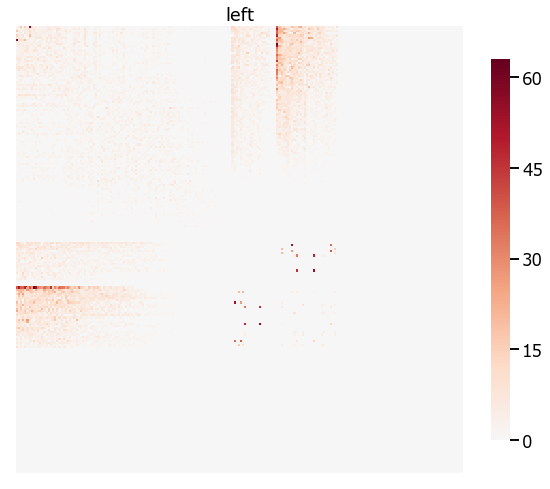

In [11]:
heatmap(left, title='left')

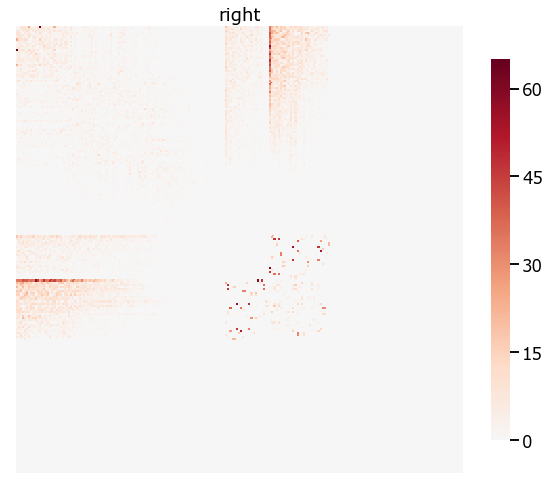

In [12]:
heatmap(right, title='right')

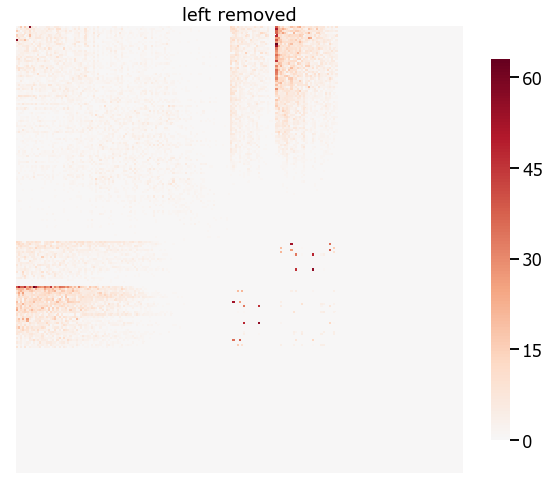

In [13]:
heatmap(left_rm, title='left removed')

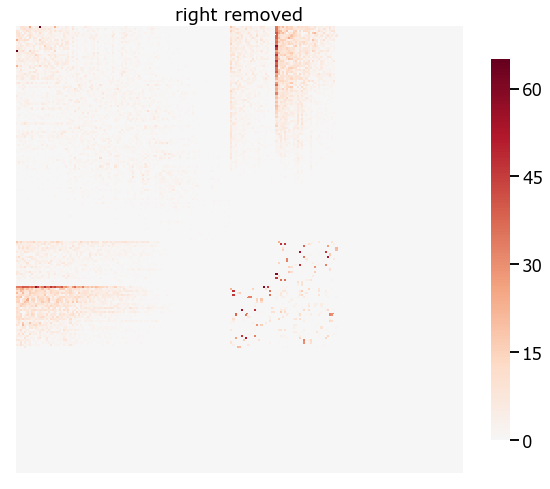

In [14]:
heatmap(right_rm, title='right removed')

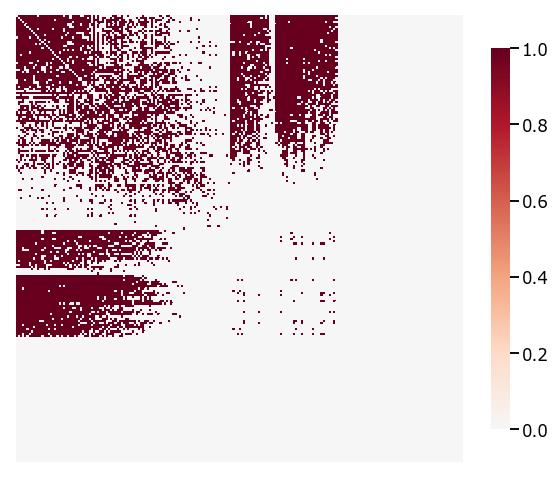

In [20]:
heatmap(binarize(left_rm))

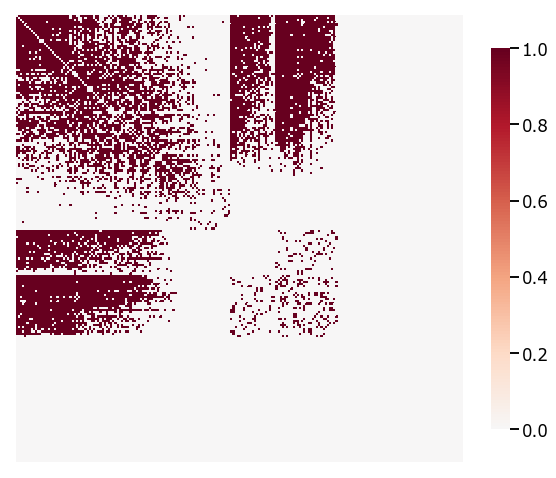

In [21]:
heatmap(binarize(right_rm))

In [47]:
block_assignment = estimate_block_assignment(left_rm, right_rm, k=100, set_k=False, num_repeats=10)

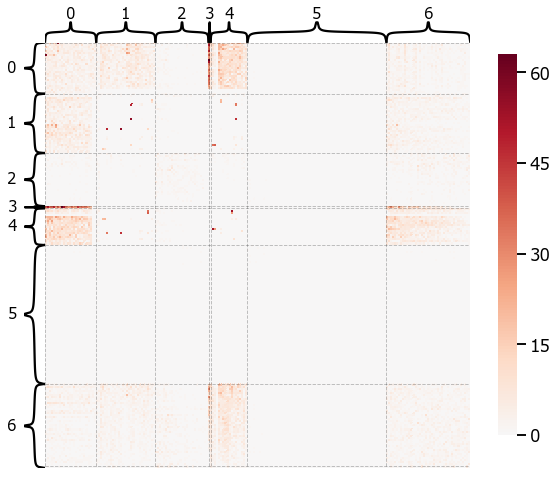

In [48]:
heatmap(left_rm, inner_hier_labels=block_assignment, title='left')

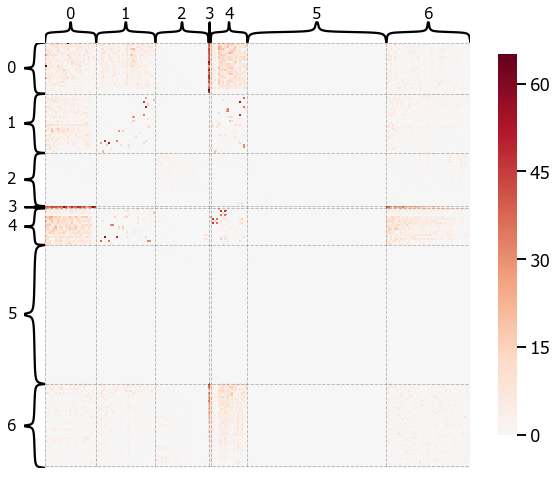

In [49]:
heatmap(right_rm, inner_hier_labels=block_assignment)

In [50]:
mgc = MGC(compute_distance_matrix=identity)
mgc.test_statistic(to_distance_mtx(left_rm), to_distance_mtx(right_rm))

In [59]:
k_arr = np.logspace(start=1, stop=7, num=7, base=2, dtype=int)
reps = 200
test_stats_null_arr = np.zeros((k_arr.size, reps))
for i, k in enumerate(k_arr):
    for r in tqdm(range(reps)):
        block_assignment = estimate_block_assignment(left_rm, right_rm, k=k, set_k=True, num_repeats=50)
        test_stats_null, _ = mgc.test_statistic(to_distance_mtx(block_permute(left_rm, block_assignment)), 
                   to_distance_mtx(sort_graph(right_rm, block_assignment)))
        test_stats_null_arr[i, r] = test_stats_null

100%|██████████| 200/200 [22:56<00:00,  7.10s/it]


[]

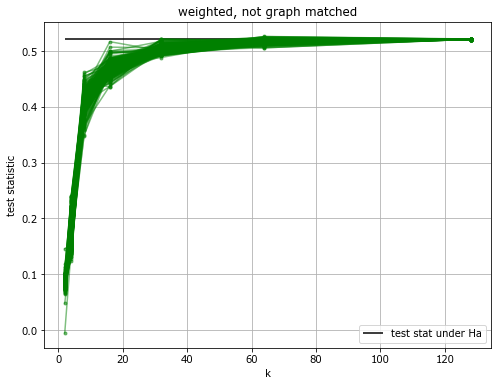

In [17]:
test_stats_null_arr = np.load('../results/drosophila_weighted_nomatch_teststats_null.npy')
mgc = MGC(compute_distance_matrix=identity)
test_stats_alt = mgc.test_statistic(to_distance_mtx(left_rm), to_distance_mtx(right_rm))[0]
k_arr = np.logspace(start=1, stop=7, num=7, base=2, dtype=int)
plt.figure(figsize=(8, 6))
for i in range(test_stats_null_arr.shape[1]):
    plt.plot(k_arr, test_stats_null_arr[:, i], color='g', marker='.', alpha=0.5)
plt.hlines(y=test_stats_alt, xmin=min(k_arr), xmax=max(k_arr), label='test stat under Ha')
plt.xlabel('k')
plt.ylabel('test statistic')
plt.legend(loc=4)
plt.grid()
plt.title('weighted, not graph matched')
plt.plot()

In [19]:
for k in k_arr:
    print('k: {}, p-value: {}'.format(k, pval_from_null_dist(k)))

k: 2, p-value: 0.0
k: 4, p-value: 0.0
k: 8, p-value: 0.0
k: 16, p-value: 0.0
k: 32, p-value: 0.005
k: 64, p-value: 0.155
k: 128, p-value: 0.14
